In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [13]:
# Set paths
DATASET_PATH = "Deforestation_Data/train/"

# Image size and batch size
IMG_SIZE = (128,128)
BATCH_SIZE = 16

# Load images function
def load_images(folder, label):
    images, labels = [], []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        try:
            img = load_img(img_path, target_size=IMG_SIZE, color_mode="rgb")  # Convert grayscale to 3-channel
            img_array = img_to_array(img) / 255.0  # Normalize
            images.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Skipping corrupted image {file}: {e}")
    return np.array(images), np.array(labels)

# Load images
deforestation_images, deforestation_labels = load_images(os.path.join(DATASET_PATH, "Deforestation"), 1)
normal_images, normal_labels = load_images(os.path.join(DATASET_PATH, "Normal"), 0)

Skipping corrupted image -73.15884,46.38819.jpg: image file is truncated (51 bytes not processed)


In [14]:
# Combine dataset
X = np.concatenate([deforestation_images, normal_images], axis=0)
y = np.concatenate([deforestation_labels, normal_labels], axis=0)

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:


# **Build ResNet Model**
def build_resnet_classifier():
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

    # Freeze initial layers (only fine-tune deeper layers)
    for layer in base_model.layers[:140]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),  # Reduce overfitting
        layers.Dense(1, activation="sigmoid")  # Binary classification
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])
    model.summary()
    return model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 15,240,449 (58.14 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

<Sequential name=sequential, built=True>

In [34]:
# Train the model
classifier = build_resnet_classifier()
history = classifier.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=BATCH_SIZE)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 15,240,449 (58.14 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

Epoch 1/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 187s 538ms/step - accuracy: 0.8614 - loss: 0.3678 - val_accuracy: 0.6437 - val_loss: 0.6058
Epoch 2/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 165s 523ms/step - accuracy: 0.8729 - loss: 0.3167 - val_accuracy: 0.5960 - val_loss: 0.7108
Epoch 3/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 166s 528ms/step - accuracy: 0.8781 - loss: 0.2898 - val_accuracy: 0.8532 - val_loss: 0.3939
Epoch 4/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 167s 530ms/step - accuracy: 0.8937 - loss: 0.2553 - val_accuracy: 0.4492 - val_loss: 1.3491
Epoch 5/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 167s 530ms/step - accuracy: 0.8969 - loss: 0.2532 - val_accuracy: 0.9087 - val_loss: 0.2351


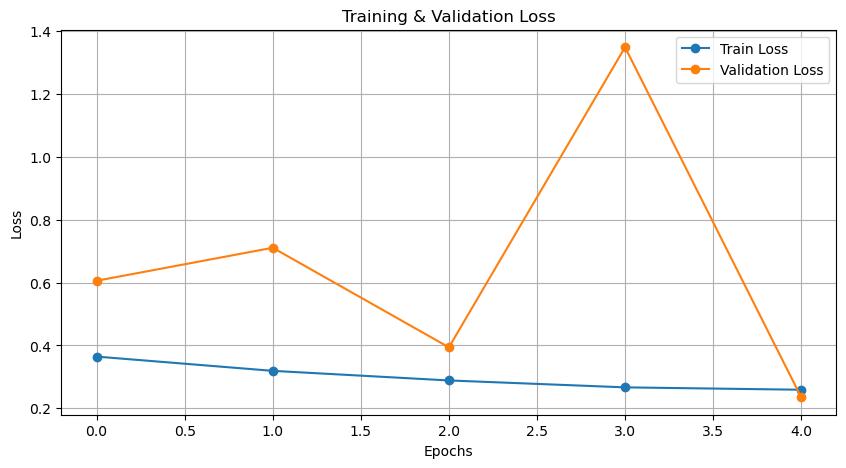

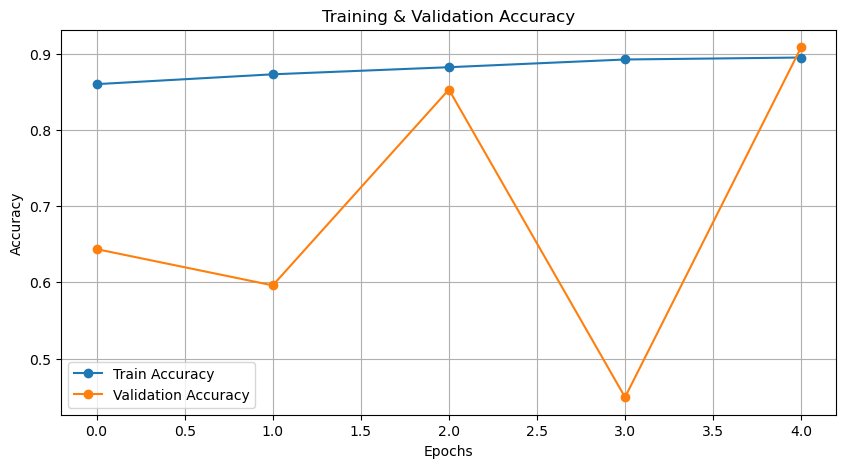

40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 510ms/step


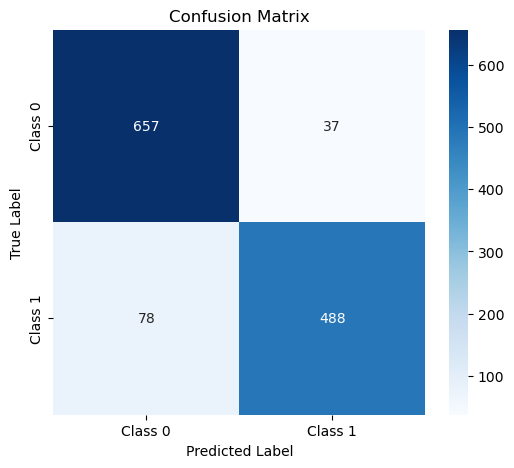

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step


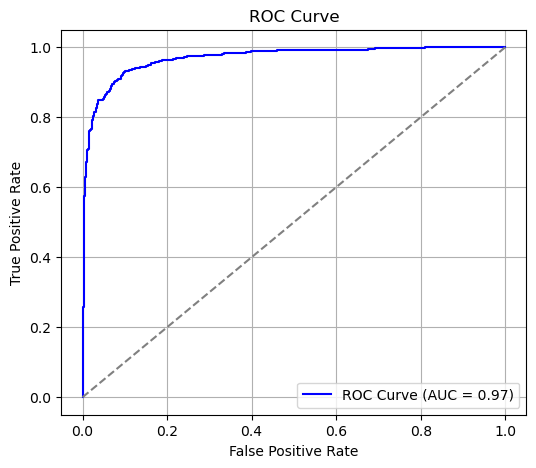

In [36]:

# --- Plot Training & Validation Loss ---
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history["loss"], label="Train Loss", marker='o')
    plt.plot(history.history["val_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training & Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history["accuracy"], label="Train Accuracy", marker='o')
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call function after training
plot_training_history(history)

# --- Confusion Matrix ---
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call function after training
plot_confusion_matrix(classifier, X_test, y_test)

# --- ROC Curve ---
def plot_roc_curve(model, X_test, y_test):
    y_probs = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call function after training
plot_roc_curve(classifier, X_test, y_test)

In [17]:
# **Save the trained model**
MODEL_PATH = "deforestation_resnet_model.h5"
classifier.save(MODEL_PATH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🛑 Deforestation Detected! Identifying affected areas...


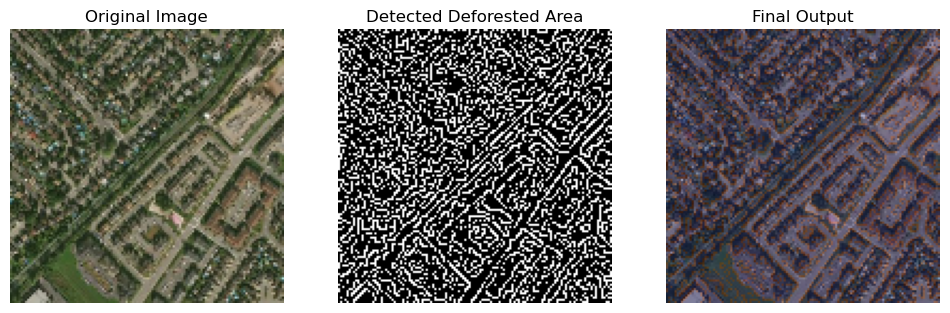

In [6]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the trained model
MODEL_PATH = "deforestation_resnet_model.h5"  # Replace with your trained model path
classifier = tf.keras.models.load_model(MODEL_PATH)

# Define image size (use the same size as during model training)
IMG_SIZE = (128, 128)

# **Deforestation Prediction Function**
def predict_deforestation(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=IMG_SIZE, color_mode="rgb")
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch processing

    # Make prediction
    prediction = classifier.predict(img_array)[0][0]

    if prediction > 0.5:
        print("🛑 Deforestation Detected! Identifying affected areas...")

        # Get refined deforestation mask
        original, mask = refine_deforestation_mask(image_path)

        # Convert mask to color and overlay it
        mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        output = cv2.addWeighted(original, 0.7, mask_colored, 0.3, 0)

        # Display results
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Detected Deforested Area")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.title("Final Output")
        plt.axis("off")

        plt.show()

    else:
        print("✅ No deforestation detected.")
        original, _ = refine_deforestation_mask(image_path)
        plt.figure(figsize=(6, 5))
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Original Image - No Deforestation")
        plt.axis("off")
        plt.show()

# **Refine Deforestation Mask Function**
def refine_deforestation_mask(image_path):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding (to detect clear deforested areas)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 5)

    # Use Canny edge detection to detect strong boundaries of deforested regions
    edges = cv2.Canny(thresh, 50, 150)

    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask and draw contours
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    return img, mask

# **Run on a test image**
test_image_path = "Deforestation_Data/test/Deforestation/-73.43705,45.463087.jpg"
predict_deforestation(test_image_path)
